<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/dev/notebooks/barley_seed_shape_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 大麦種子形状解析

## ライセンス
<img width=50% src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs42003-020-0905-5/MediaObjects/42003_2020_905_Fig1_HTML.png?as=webp">

Toda et al., Comms. Biol. 2020より引用

- Toda, Y., Okura, F., Ito, J. et al. Training instance segmentation neural network with synthetic datasets for crop seed phenotyping. Commun Biol 3, 173 (2020).
    - https://www.nature.com/articles/s42003-020-0905-5
    - CC-BY-4.0
- データセットおよび学習済みモデル
    - CC-BY-NC-4.0
- 本ノートブック
    - CC-BY-NC-4.0

## 解説

「イネ種子計数形状解析」などのノートブックでは、Otsu法やWatershedなど、基本的な画像解析手法のみで種子の測定を行いました。最適な手法と閾値（特徴量）が求まれば、高速な解析が可能です。しかし、種子の形状や一度に測定したい品種の数によっては、このような単純な手法ではうまくいかない場合があります。例えば、品種や形状ごとに最適な特徴量を求める必要があったり、種子の形状が複雑で特徴量の設計が難しい場合などです。

このような場合には、機械学習（深層学習）を用いた画像解析が有効な場合があります。このノートブックでは、インスタンス・セグメンテーションを行うための深層学習アルゴリズム「Mask-RCNN」をした、形状解析方法を紹介します。

Mask-RCNNの学習には教師データが必要です。具体的には種子の輪郭を１つ１つなぞった座標を記入したアノテーションファイルが必要となります。数千粒のアノテーションは労力と時間がとてもかかり、また、アノテーションの精度も作業者によって異なるため、アノテーション作業は非常に困難です。そこで、本ノートブックでは、アノテーション作業を簡略化するために、合成画像を用いた教師データによって訓練を行いました。詳細は論文をご参照ください。本ノートブックでは、onnx形式に変換したモデルファイルを使い、推論を行います。

## 備考

本ノートブックでは深層学習のフレームワークにONNXを使用します。colaboratoryではONNX推論エンジンであるonnxruntime (gpu対応の場合はonnxruntime-gpu)がプレインストールされていないため、pipでインストールする必要があります。しかしながら、2023年12月現在、colaboratoryの環境はubuntu 22.04にCUDA12.2がインストールされている一方、最新版であるonnxruntime-gpu==1.16はCUDA11.6~11.8にしか対応していません。従ってGPU推論を行いたい場合、環境構築の項目にある"CUDA 11.8へのダウングレード"のコードセルを実行し、CUDAをダウングレードします。ただし、実行にある程度の時間がかかるため、飛ばしてもかまいません。（その場合、自動的にCPU推論に切り替わります。１〜２枚程度の推論ならCPUでも問題ありませんが、数十枚の画像を処理する場合はGPUが推奨されます。それぞれの待ち時間との塩梅で判断してください）

## 環境構築

In [6]:
!pip install -q onnxruntime
!git clone https://github.com/matterport/Mask_RCNN.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.4 MB/s eta 0:00:00


In [1]:
import sys
sys.path.append("Mask_RCNN")

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import mrcnn
from mrcnn import utils, visualize, config

公式レポジトリのMaskRCNN classより、必要な前処理、後処理のコード部分を単離します。mrcnnのmodel.pyにはkeras1由来のプログラムコードによりインポートエラーが起きるため、model.pyにある関数・クラスはノートブックに記述しなおします。

In [3]:
def compose_image_meta(image_id, original_image_shape, image_shape,
                       window, scale, active_class_ids):
    meta = np.array(
        [image_id] +                  # size=1
        list(original_image_shape) +  # size=3
        list(image_shape) +           # size=3
        list(window) +                # size=4 (y1, x1, y2, x2) in image cooredinates
        [scale] +                     # size=1
        list(active_class_ids)        # size=num_classes
    )
    return meta

def compute_backbone_shapes(config, image_shape):
    if callable(config.BACKBONE):
        return config.COMPUTE_BACKBONE_SHAPE(image_shape)
    assert config.BACKBONE in ["resnet50", "resnet101"]
    return np.array(
        [[int(math.ceil(image_shape[0] / stride)),
            int(math.ceil(image_shape[1] / stride))]
            for stride in config.BACKBONE_STRIDES])

def get_anchors(image_shape, config):
    """Returns anchor pyramid for the given image size."""
    backbone_shapes = compute_backbone_shapes(config, image_shape)
    _anchor_cache = {}
    a = utils.generate_pyramid_anchors(
        config.RPN_ANCHOR_SCALES,
        config.RPN_ANCHOR_RATIOS,
        backbone_shapes,
        config.BACKBONE_STRIDES,
        config.RPN_ANCHOR_STRIDE)
    anchors = a
    _anchor_cache[tuple(image_shape)] = utils.norm_boxes(a, image_shape[:2])
    return _anchor_cache[tuple(image_shape)]

def prepare_inputs(image, config):
    molded_image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

    molded_image = molded_image.astype(np.float32) - config.MEAN_PIXEL

    image_meta = compose_image_meta(
                0, image.shape, molded_image.shape, window, scale,
                np.zeros([config.NUM_CLASSES], dtype=np.int32))

    image_shape = molded_image.shape
    anchors = get_anchors(image_shape, config)
    anchors = np.broadcast_to(anchors, (config.BATCH_SIZE,) + anchors.shape)

    molded_images = np.expand_dims(molded_image,axis=0)
    molded_images = molded_images.astype(np.float32)
    image_metas = np.array([image_meta],dtype=np.float32)
    windows = np.array([window])
    return molded_images, image_metas, anchors, windows

def unmold_detections(detections, mrcnn_mask, original_image_shape,
                          image_shape, window):
        zero_ix = np.where(detections[:, 4] == 0)[0]
        N = zero_ix[0] if zero_ix.shape[0] > 0 else detections.shape[0]
        boxes = detections[:N, :4]
        class_ids = detections[:N, 4].astype(np.int32)
        scores = detections[:N, 5]
        masks = mrcnn_mask[np.arange(N), :, :, class_ids]
        window = utils.norm_boxes(window, image_shape[:2])
        wy1, wx1, wy2, wx2 = window
        shift = np.array([wy1, wx1, wy1, wx1])
        wh = wy2 - wy1
        ww = wx2 - wx1
        scale = np.array([wh, ww, wh, ww])
        boxes = np.divide(boxes - shift, scale)
        boxes = utils.denorm_boxes(boxes, original_image_shape[:2])
        exclude_ix = np.where(
            (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]) <= 0)[0]
        if exclude_ix.shape[0] > 0:
            boxes = np.delete(boxes, exclude_ix, axis=0)
            class_ids = np.delete(class_ids, exclude_ix, axis=0)
            scores = np.delete(scores, exclude_ix, axis=0)
            masks = np.delete(masks, exclude_ix, axis=0)
            N = class_ids.shape[0]
        full_masks = []
        for i in range(N):
            full_mask = utils.unmold_mask(masks[i], boxes[i], original_image_shape)
            full_masks.append(full_mask)
        full_masks = np.stack(full_masks, axis=-1)\
            if full_masks else np.empty(original_image_shape[:2] + (0,))
        return boxes, class_ids, scores, full_masks

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import onnxruntime as ort
print("Available providers:", ort.get_available_providers())

Available providers: ['AzureExecutionProvider', 'CPUExecutionProvider']


## Mask-RCNN

In [5]:
model_path = "/content/drive/MyDrive/barley_maskrcnn/model_weights/barley_maskrcnn.onnx"
providers = [
    'CUDAExecutionProvider', 'CPUExecutionProvider' \
    if "CUDAExecutionProvider" in ort.get_available_providers() \
    else ['CPUExecutionProvider']
    ]
ort_session = ort.InferenceSession(model_path, providers=providers)
print(ort_session.get_providers())

input_names = [input.name for input in ort_session.get_inputs()]
output_names = [output.name for output in ort_session.get_outputs()]

print("Input names:", input_names)
print("Output names:", output_names)

/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


EP Error 'providers' values must be either strings or (string, dict) tuples. when using ['CUDAExecutionProvider', ['CPUExecutionProvider']]
Falling back to ['CPUExecutionProvider'] and retrying.
['CPUExecutionProvider']
Input names: ['input_image', 'input_image_meta', 'input_anchors']
Output names: ['mrcnn_detection', 'mrcnn_class', 'mrcnn_bbox', 'mrcnn_mask', 'ROI', 'rpn_class', 'rpn_bbox']


In [6]:
class InferenceConfig(config.Config):
    NAME = "seed"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # background + 1 seeds

    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 1024
    IMAGE_RESIZE_MODE = "square"

    DETECTION_MAX_INSTANCES = 1000
    RPN_NMS_THRESHOLD = 0.4
    DETECTION_MIN_CONFIDENCE = 0

    MEAN_PIXEL = np.array([123.7, 116.8, 103.9])

In [11]:
!ls /content/drive/MyDrive/barley_maskrcnn/realworld_test/image/

B669.jpg  C346.jpg  E245.jpg  H602.jpg	I335.jpg  I626.jpg  J247.jpg  K692.jpg	N009.jpg  U051.jpg
C319.jpg  C656.jpg  E612.jpg  I304.jpg	I622.jpg  J064.jpg  J647.jpg  K735.jpg	T567.jpg  U353.jpg


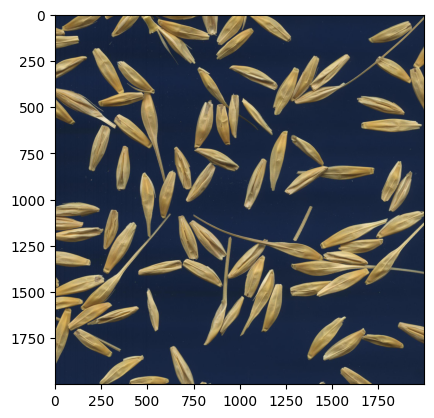

In [12]:
image = cv2.imread("/content/drive/MyDrive/barley_maskrcnn/realworld_test/image/B669.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [7]:
configuration= InferenceConfig()
# 画像を読み込み、configをもとにメタデータ、アンカー、ウィンドウなど推論に必要な情報を生成します。
molded_images, image_metas, anchors, windows = prepare_inputs(image, configuration)

NameError: name 'image' is not defined

In [30]:
%%time

#cpu推論の場合１分程度必要
predictions = ort_session.run(
    ['mrcnn_detection', 'mrcnn_class', 'mrcnn_bbox', 'mrcnn_mask', 'ROI', 'rpn_class', 'rpn_bbox'],
    {"input_image": molded_images,
     "input_image_meta": image_metas,
     "input_anchors": anchors})

CPU times: user 1min 7s, sys: 2.86 s, total: 1min 10s
Wall time: 1min 15s


In [24]:
#['mrcnn_detection', 'mrcnn_class', 'mrcnn_bbox', 'mrcnn_mask', 'ROI', 'rpn_class', 'rpn_bbox']
print(len(predictions[0]))

1


In [25]:
molded_images.shape

(1, 512, 512, 3)

In [31]:
# 出力結果のうち、mrcnn_detectionとmrcnn_maskしか使わない。
detections = predictions[0]
mrcnn_mask = predictions[3]

results = []
final_rois, final_class_ids, final_scores, final_masks =\
    unmold_detections(detections[0], mrcnn_mask[0],
                            image.shape, molded_images[0].shape,
                            windows[0])
results.append({
    "rois": final_rois,
    "class_ids": final_class_ids,
    "scores": final_scores,
    "masks": final_masks,
})
r = results[0]

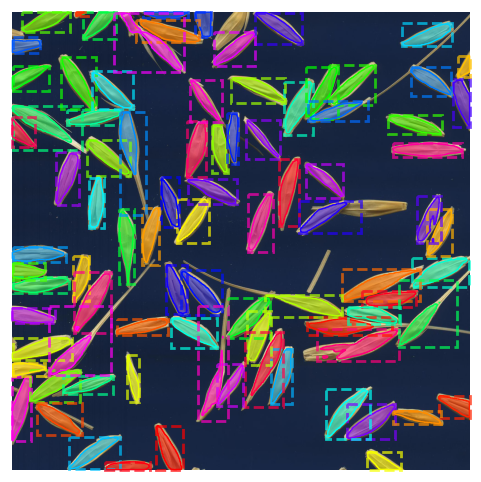

In [32]:
visualize.display_instances(
            image, r['rois'], r['masks'], r['class_ids'],
            ["",""], ["" for x in range(len(r['scores']))],  # ラベル名や検出確率は空白にします
            show_bbox=True, show_mask=True,
            figsize=(6,6))

## 形状解析

推論結果の後処理から得られたr["masks"]には、検出された物体１つ１つのmask画像が格納されています。
これらをskimage.measureのlabel, regionpropsで形状解析すれば種子の形を求めることができます。(形状抽出の方法については他ノートブックで詳しく解説しているので省略します。)

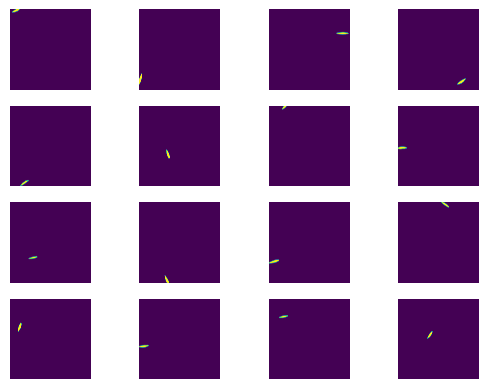

In [33]:
for i in range(16):
    plt.subplot(4,4, i+1)
    plt.imshow(r["masks"][..., i])
    plt.axis("off")

それではデータセットディレクトリにある画像を解析してみましょう。
１画像につき、１品種の種子の画像が含まれています。
まずはどのようなファイルがあるか確認します。

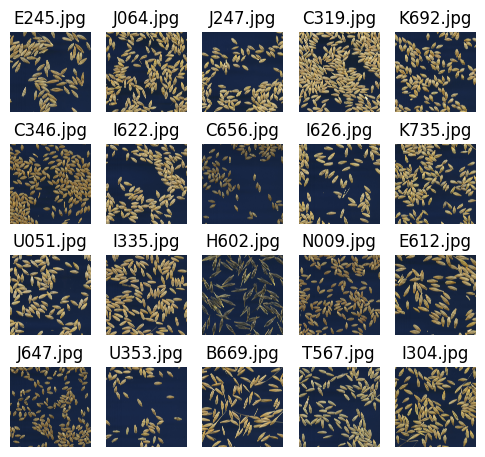

In [8]:
DATASET_DIR = "/content/drive/MyDrive/barley_maskrcnn/realworld_test/image"
files = os.listdir(DATASET_DIR)

plt.figure(figsize=(6,7))
for i, file in enumerate(files):
    path = os.path.join(DATASET_DIR, file)
    image = cv2.imread(path)[...,::-1]
    plt.subplot(5,5, i+1)
    plt.imshow(image)
    plt.title(file)
    plt.axis("off")
plt.subplots_adjust()

In [ ]:
from skimage.measure import label, regionprops
import os

def extract_features(mask):
    lbl = label(mask)
    props = regionprops(lbl)
    # get the largest area label
    idx = np.argmax([x.area for x in props])
    prop = props[idx]
    return prop.area, prop.axis_minor_length, prop.axis_major_length

def predict(path):
    configuration = InferenceConfig()

    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    molded_images, image_metas, anchors, windows = prepare_inputs(image, configuration)
    predictions = ort_session.run(
        ['mrcnn_detection', 'mrcnn_class', 'mrcnn_bbox', 'mrcnn_mask', 'ROI', 'rpn_class', 'rpn_bbox'],
        {"input_image": molded_images,
        "input_image_meta": image_metas,
        "input_anchors": anchors})
    detections = predictions[0]
    mrcnn_mask = predictions[3]

    results = []
    final_rois, final_class_ids, final_scores, final_masks =\
        unmold_detections(detections[0], mrcnn_mask[0],
                                image.shape, molded_images[0].shape,
                                windows[0])
    results.append({
        "rois": final_rois,
        "class_ids": final_class_ids,
        "scores": final_scores,
        "masks": final_masks,
    })
    r = results[0]
    return r["masks"]

results = []

for file in files:
    path = os.path.join(DATASET_DIR, file)
    masks = predict(path)
    masks = masks.transpose(2,0,1)
    for mask in masks:
        area, width, length = extract_features(mask)
        results.append([file, area, width, length])

In [ ]:
import pandas as pd

df = pd.DataFrame(results, columns=["cultivar","area","width","height"])

# 外れ値の除去
def remove_outliers(group):
    for column in ['area', 'width', 'height']:
        q1 = group[column].quantile(0.25)
        q3 = group[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        group = group[(group[column] >= lower_bound) & (group[column] <= upper_bound)]
    return group

df = df.groupby('cultivar').apply(remove_outliers).reset_index(drop=True)

df

In [ ]:
import seaborn as sns

# plot singe metrics
sns.boxplot(data=df, x="cultivar", y="area", hue="cultivar",dodge=False)
sns.swarmplot(data=df, x="cultivar",y="area", hue="cultivar", palette='dark:black', legend=False)
plt.show()

# plot multiple categories
g = sns.PairGrid(df, hue="cultivar")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()
plt.show()